In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

import random

In [2]:
import layers as custom_layers

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# File Paths
imgIdxCsvPath = './MRNet/MRNet-v1.0/similar.csv'
MRI_Path = './MRNet/MRNet-v1.0/train/axial/{}.npy'

## Load MRNet data as moving images

In [ ]:
# Get indices of qualified training images in MRNet.
imageIndices = []
with open(imgIdxCsvPath) as file:
    fileReader = csv.reader(file)
    # Find all the rows with abnormal as 0 and store their indices
    for row in fileReader:
        index = str(row[0])
        while(len(index) < 4):
            index = '0' + index
        imageIndices.append(index)

In [ ]:
print(imageIndices)

In [ ]:
# Check which image has most slices, then we use it as our atlas/target/fixed image.
maxSlice = 0
targetIndex = None
for index in imageIndices:
    img = np.load(MRI_Path.format(index))
    if (img.shape[0] > maxSlice):
        targetIndex = index
        maxSlice = img.shape[0]
    
print(maxSlice)
print(targetIndex)

### Load all qualified images into memory

In [ ]:
# Load fixed image.
fixedImg = np.load(MRI_Path.format(targetIndex))

In [ ]:
# Load moving images and zero-pad them.
movingImgs = []
# limit = 30
# counter = 0
for index in imageIndices:
    if index == targetIndex:
        continue
#     if counter == limit:
#         break
    img = np.load(MRI_Path.format(index))
    numSlicesToPaddle = maxSlice - img.shape[0]
    img = np.pad(img, ((0, numSlicesToPaddle), (0, 0), (0, 0)))
    movingImgs.append(img)
#     counter += 1

In [ ]:
# Append the channel axis to moving images and the fixed image.
fixedImg = np.expand_dims(fixedImg, axis=-1)
for i in range(len(movingImgs)):
    movingImgs[i] = np.expand_dims(movingImgs[i], axis=-1)
print(movingImgs[0].shape)
print(fixedImg.shape)

In [ ]:
movingImgs = np.array(movingImgs)
print(movingImgs.shape)

In [ ]:
fixedImgs = np.repeat(fixedImg[np.newaxis,...], movingImgs.shape[0], axis = 0)
print(fixedImgs.shape)

In [ ]:
print(movingImgs.dtype)

In [ ]:
movingImgs = movingImgs.astype('float32')
fixedImgs = fixedImgs.astype('float32')

In [ ]:
print(movingImgs.dtype)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((movingImgs, fixedImgs))
batch_size = 1
dataset.batch(batch_size)

In [ ]:
print(dataset.element_spec)

### Load data by data generators

In [ ]:
fixedImg = np.load(MRI_Path.format(targetIndex))
fixedImg = np.expand_dims(fixedImg, axis=-1)
fixedImg = fixedImg.astype('float32')
def data_generator(batchSize = 1):
    while True:
        movingImgs = []
        fixedImgs = []
        for i in range(batchSize):
            idx = random.randrange(len(imageIndices))
            fileIdx = imageIndices[idx]
            movingImg = np.load(MRI_Path.format(fileIdx))
            numSlicesToPaddle = maxSlice - movingImg.shape[0]
            movingImg = np.pad(movingImg, ((0, numSlicesToPaddle), (0, 0), (0, 0)))
            movingImg = np.expand_dims(movingImg, axis=-1)
            movingImg = movingImg.astype('float32')
            movingImgs.append(movingImg)
            fixedImgs.append(fixedImg)
        movingImgs = np.array(movingImgs)
        fixedImgs = np.array(fixedImgs)
        yield (movingImgs, fixedImgs)

## Load self-generated training data (by data loaders)

### Duplicate fixed image as labels

In [5]:
trainDataPath = "./affineTrainingData/affine{}.npz"
fixedImg = np.load(MRI_Path.format("0701"))
fixedImg = np.expand_dims(fixedImg, axis=-1)
fixedImg = fixedImg.astype('float')
def data_generator(batchSize = 1):
    while True:
        movingImgs = []
        fixedImgs = []
        for i in range(batchSize):
            idx = random.randrange(200)
            movingImg = np.load(trainDataPath.format(idx))['img']
#             numSlicesToPaddle = maxSlice - movingImg.shape[0]
#             movingImg = np.pad(movingImg, ((0, numSlicesToPaddle), (0, 0), (0, 0)))
#             movingImg = np.expand_dims(movingImg, axis=-1)
            movingImg = movingImg.astype('float')
            movingImgs.append(movingImg)
            fixedImgs.append(fixedImg)
        movingImgs = np.array(movingImgs)
        fixedImgs = np.array(fixedImgs)
        yield (movingImgs, fixedImgs)

### Load ground-truth affine transformation parameters as labels

In [ ]:
trainDataPath = "./affineTrainingData/affine{}.npz"
fixedImg = np.load(MRI_Path.format("0701"))
fixedImg = np.expand_dims(fixedImg, axis=-1)
fixedImg = fixedImg.astype('float32')
def data_generator(batchSize = 1):
    while True:
        movingImgs = []
        labels = []
        for i in range(batchSize):
            idx = random.randrange(200)
            data = np.load(trainDataPath.format(idx))
            movingImg = data["img"]
#             numSlicesToPaddle = maxSlice - movingImg.shape[0]
#             movingImg = np.pad(movingImg, ((0, numSlicesToPaddle), (0, 0), (0, 0)))
#             movingImg = np.expand_dims(movingImg, axis=-1)
            movingImg = movingImg.astype('float32')
            movingImgs.append(movingImg)
            labels.append(data["trf"])
        movingImgs = np.array(movingImgs)
        labels = np.array(labels)
        yield (movingImgs, labels)

In [11]:
dataGen = data_generator()

## NN with labels as fixed images

In [6]:
# Construct NN
# nFeats = 1
# for i in range(len(fixedImg.shape)):
#     nFeats *= fixedImg.shape[i]
# print(nFeats)
inputs = keras.Input(shape = fixedImg.shape)
print(inputs.shape)
conv_0 = layers.Conv3D(filters=2, kernel_size=(3, 10, 10), activation="relu")(inputs)
conv_1 = layers.Conv3D(filters=3, kernel_size=(3, 15, 15), activation="relu")(conv_0)
filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(conv_1)
conv_2 = layers.Conv3D(filters=4, kernel_size=(3, 15, 15), activation="relu")(filtered_conv_1)
filtered_conv_2 = layers.MaxPool3D((1, 2, 2))(conv_2)
print(filtered_conv_2.shape)
conv_3 = layers.Conv3D(filters=2, kernel_size=(6, 20, 20), activation="relu")(filtered_conv_2)
conv_4 = layers.Conv3D(filters=1, kernel_size=(6, 10, 10), activation="relu")(conv_3)
print(conv_4.shape)
flattened = layers.Flatten()(conv_4)
print(flattened.shape)
dense_0 = layers.Dense(256, activation="relu")(flattened)
affine_pred = layers.Dense(12, activation="relu")(dense_0)
warped = custom_layers.SpatialTransformer(interp_method='linear')([inputs, affine_pred])
print(warped.shape)

(None, 52, 256, 256, 1)
(None, 22, 51, 51, 4)
(None, 12, 23, 23, 1)
(None, 6348)
Instructions for updating:
Use fn_output_signature instead
(None, 52, 256, 256, 1)


## NN with ground-truth affine transformation parameters as labels

In [ ]:
# Construct NN
# nFeats = 1
# for i in range(len(fixedImg.shape)):
#     nFeats *= fixedImg.shape[i]
# print(nFeats)
inputs = keras.Input(shape = fixedImg.shape)
print(inputs.shape)
conv_0 = layers.Conv3D(filters=2, kernel_size=(3, 10, 10), activation="relu")(inputs)
conv_1 = layers.Conv3D(filters=3, kernel_size=(3, 15, 15), activation="relu")(conv_0)
filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(conv_1)
conv_2 = layers.Conv3D(filters=4, kernel_size=(3, 15, 15), activation="relu")(filtered_conv_1)
filtered_conv_2 = layers.MaxPool3D((1, 2, 2))(conv_2)
print(filtered_conv_2.shape)
conv_3 = layers.Conv3D(filters=2, kernel_size=(6, 20, 20), activation="relu")(filtered_conv_2)
conv_4 = layers.Conv3D(filters=1, kernel_size=(6, 10, 10), activation="relu")(conv_3)
print(conv_4.shape)
flattened = layers.Flatten()(conv_4)
print(flattened.shape)
dense_0 = layers.Dense(256, activation="relu")(flattened)
affine_pred = layers.Dense(12, activation="relu")(dense_0)

In [7]:
model = keras.Model(inputs=inputs, outputs=warped, name="affine_model")
model.summary()

Model: "affine_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 52, 256, 256 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 50, 247, 247, 602         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 48, 233, 233, 4053        conv3d[0][0]                     
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 24, 116, 116, 0           conv3d_1[0][0]                   
_______________________________________________________________________________________

In [8]:
lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
loss_object = tf.keras.losses.MeanSquaredError()

loss_history = []
save_callback = ModelCheckpoint('./checkpoints/{epoch:02d}.h5')

In [9]:
model.compile(optimizer=optimizer, loss=loss_object)

In [12]:
model.fit(dataGen, epochs=50, steps_per_epoch=200, callbacks=[save_callback])

Epoch 1/50
200/200 [==============================] - 346s 2s/step - loss: 5835.0661
Epoch 2/50
200/200 [==============================] - 342s 2s/step - loss: 3040.7650
Epoch 3/50
200/200 [==============================] - 328s 2s/step - loss: 3091.8920
Epoch 4/50
200/200 [==============================] - 325s 2s/step - loss: 3147.4223
Epoch 5/50
 23/200 [==>...........................] - ETA: 4:54 - loss: 3168.9109

KeyboardInterrupt: 

## Custom training function

In [ ]:
'''
Training step for each epoch
'''
def train_step(movingImages, fixedImages):
  with tf.GradientTape() as tape:
    warpedImages = model(movingImages, training=True)

    # Add asserts to check the shape of the output.
    #tf.debugging.assert_equal(logits.shape, (32, 10))

    loss_value = loss_object(warpedImages, fixedImages)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
def train(epochs):
  for epoch in range(epochs):
    for (batch, (movingImages, fixedImages)) in enumerate(dataset):
        movingImages = movingImages[np.newaxis,...]
        fixedImages = fixedImages[np.newaxis,...]
        train_step(movingImages, fixedImages)
    print ('Epoch {} finished. Current loss value: {}'.format(epoch, loss_history[-1]))
    model.save_weights('./checkpoints/epoch_{}'.format(epoch))

In [ ]:
epochs = 50
train(epochs)

## Test model (output == warpedImg)

In [13]:
testModel = keras.Model(inputs=inputs, outputs=warped)

In [14]:
# testModel.load_weights('./checkpoints/epoch_{}'.format(epochs-1))
testModel.load_weights('./checkpoints/03.h5')

In [22]:
warped_test = testModel(next(dataGen)[0])

In [23]:
print(warped_test.shape)
print(np.sum(warped_test))

(1, 52, 256, 256, 1)
168982370.0


## Test model (output == ground-truth affine trf param)

In [ ]:
testModel = keras.Model(inputs=inputs, outputs=affine_pred)

In [ ]:
testModel.load_weights('./checkpoints/48.h5')

In [ ]:
testImg, testLabel = next(dataGen)
testAffineParam = testModel(testImg)
print(testAffineParam)
print(np.sum(testImg))
print(testLabel)

In [ ]:
# testImg = np.load(trainDataPath.format("3"))['img']
# testImg = testImg.astype('float')
# print(np.sum(testImg))
# testImg = testImg[np.newaxis, ..., np.newaxis]
# testAffineParam = testModel(testImg)
# print(testAffineParam)

In [ ]:
testAffineParam = np.reshape(testAffineParam, (3, 4))
testLabel = np.reshape(testLabel, (3, 4))
eyeRow = np.array([[0, 0, 0, 1]])
testAffineParam = np.concatenate((testAffineParam, eyeRow), axis=0)
testLabel = np.concatenate((testLabel, eyeRow), axis=0)

In [ ]:
print(testLabel)

In [ ]:
print(testAffineParam)

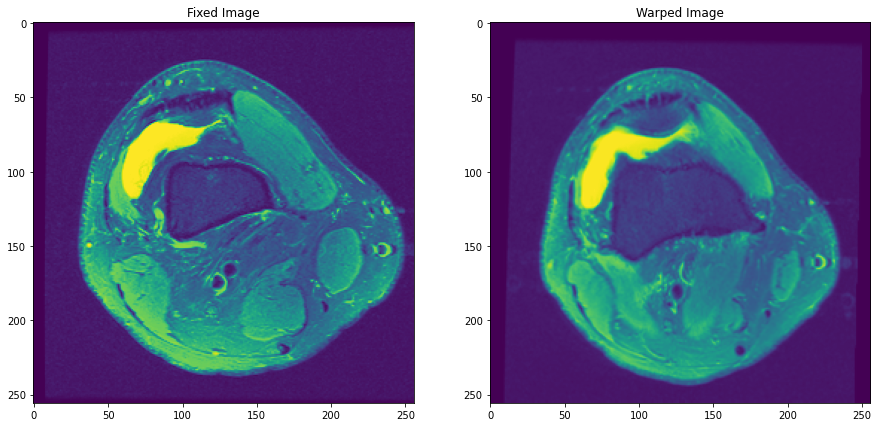

In [24]:
sliceToCheck = 10
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(fixedImg[sliceToCheck,:,:,0])
axs[0].set_title("Fixed Image")
# axs[1].imshow(movingImgs[0,sliceToCheck,:,:,0])
# axs[1].set_title("Moving Image")
axs[1].imshow(warped_test[0,sliceToCheck,:,:,0])
axs[1].set_title("Warped Image")
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(len(loss_history)), loss_history)

In [ ]:
n = np.array([1., 2., 4.])
t = tf.constant(n)
print(t.shape)
print(t.shape.as_list())